# ***Sentiment Analysis***
Sentiment analysis is the process of detecting positive or negative sentiment in text. It’s often used by businesses to detect sentiment in social data, gauge brand reputation, and understand customers’ likes & dislikes. Since customers express their thoughts and feelings more openly than ever before, sentiment analysis is becoming an essential tool to monitor and understand that sentiment. Automatically analyzing customer feedback, such as opinions in survey responses and social media conversations, allows brands to learn what makes customers happy or frustrated. By virtue of knowing customer preference and feedback, companies are able to timely tailor products & services to meet their customers’ needs and expectations. For example, using sentiment analysis to automatically analyze 4,000+ reviews about your product could help you discover if customers are happy about your product acceptance and its value for money. 


# ***Data Collection***
I have retrieved data of US 2020 election with hashtag of Donald Trump and Joe Biden from Kaggle (https://www.kaggle.com/manchunhui/us-election-2020-tweets). It contains almost 900000 tweets related to Donald Trump and 700000 tweets related to Joe Biden. Secondly to train my model I have retrieved labeled data with sentiments from Kaggle (https://www.kaggle.com/kazanova/sentiment140 ), It contains 1.6 million tweets annotated with sentiments.

In [ ]:
import os
from google.colab import drive
#Mounting Google Drive to access the two datasets of tweets as mentioned above
drive.mount('/content/drive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.activity.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fexperimentsandconfigs%20https%3a%2f%2fwww.googleapis.com%2fauth%2fphotos.native&response_type=code

Enter your authorization code:
4/1AY0e-g7BXvhzHOBDWFInP6E99jXxwwEoqVf5gKVlAEyflqWpYl-MckQ8H6M


In [ ]:
os.chdir('/content/drive/MyDrive/text mining project')
!ls

hashtag_donaldtrump.csv  Reviews.csv
hashtag_joebiden.csv	 training.1600000.processed.noemoticon.csv


In [ ]:
#Installing package for Python bindings for the Compact Langauge Detect 2
!pip install pycld2

     |████████████████████████████████| 41.4MB 77kB/s 
  Created wheel for pycld2: filename=pycld2-0.41-cp36-cp36m-linux_x86_64.whl size=9833537 sha256=99872e1b22d533308648a1daff932f2933782186c52f001e7093d5bf731db357
  Stored in directory: /root/.cache/pip/wheels/c6/8f/e9/08a1a8932a490175bd140206cd86a3dbcfc70498100de11079
Successfully built pycld2


# ***Libraries Loaded***

In [ ]:
import numpy as np
import pandas as pd

#NLP Library
import spacy
import re

#Language Detect Library
import pycld2 as cld2

#Feature extraction, model selection and model training library
#Hashing Vectorizer - Convert a collection of text documents to a matrix of token occurrences
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split

#Libraries to check the model performance
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

#Graphing Libraries
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

#Hypothesis Testing
import math
from scipy.stats import chi2_contingency, chisquare, chi2

# ***Data Preparation***
Data Cleansing and Data Transformation

In [ ]:
#Importing Spacy pretrained pipelines for english languague 
nlp = spacy.load("en_core_web_sm",disable=["tagger","parser","ner"])
# Disabling parts of speech tags, dependency labels, and named entity recognitions as we do not require them for our sentiment analysis


# ***Clean Tweets Using Regex***
In it I removed some special characters and words that did not add any value in the sentiments of tweets but increased processing time

In [ ]:
#Preprocessing of the data for better performance and generalization of the model
def clean_tweet_text_regex(tweet):
    tweet = tweet.lower() # to lower case
    tweet = re.sub(r"@[A-Za-z0-9]+","", tweet) # Remove @Mentions
    tweet = re.sub(r"#","", tweet) # remove # \ART[\s]+
    tweet = re.sub(r"\ART[\s]+","", tweet) # Remove RT in start
    tweet = re.sub(r"https?:\/\/\S+","", tweet) # Remove hyperlink
    tweet = re.sub("(.)\\1{2,}","\\1", tweet) # Remove more than one characters.
    tweet = re.sub(r"[^A-Za-z0-9\s]+", "",str(tweet)) #remove special characters "!"
    
    return tweet

# ***Clean Tweets Using Spacy***
I have used Spacy to remove stopwords and lemmatization (Lemmatization usually refers to doing things properly with the use of a vocabulary and morphological analysis of words, normally aiming to remove inflectional endings only and to return the base or dictionary form of a word, which is known as the lemma). Since there are a very huge number of tweets in each dataset, I have created the nlp document in chunks and then split it into spans. Now I have used spans to remove the stopwords and replace the lemma word

In [ ]:
#Function for removing the stopwords and lemmatization of the remaining words for each tweet
def clean_tweet_spacy_core(doc):
    tokens= []

    for token in doc:
        if token.is_stop:
            continue
        if token.text != token.lemma_:
            tokens.append(token.lemma_)
        else:
            tokens.append(token.text)
      
    
    tweet=" ".join(tokens)
    return tweet

In [ ]:
#Function to convert documents to spans for preprocessing
def doc_to_spans(list_of_texts, join_string=' ||| '):
    all_docs = nlp(' ||| '.join(list_of_texts))
    split_inds = [i for i, token in enumerate(all_docs) if token.text == '|||'] + [len(all_docs)]
    new_docs = [all_docs[(i + 1 if i > 0 else i):j] for i, j in zip([0] + split_inds[:-1], split_inds)]
    all_docs = None
    return new_docs 

def get_complete_spans(data,colname):
    #Split the data into 500 chunks
    splitted_frames = np.array_split(data, 500)
    docs=[]
    i = 1
    for frame in splitted_frames:
        #Append Frames into docs for preprocessing
        docs.append(doc_to_spans(frame[colname]))
    return docs

In [ ]:
def clean_tweet_spacy(data, colname):
    docs = get_complete_spans(data, colname)
    
    print("Tweets cleaning started")
    tweets = []
    
    for doces in docs:
        for doc in doces:
            tweets.append(clean_tweet_spacy_core(doc))

    print("Tweets cleanned")
    return tweets

# ***Detecting Language***
Now I have used https://pypi.org/project/pycld2/ library to detect the languages of tweets. We have only used English tweets in this project to analyze the sentiments.

In [ ]:
def detect_lang(tweet):
    try:
        isReliable, textBytesFound, details = cld2.detect(tweet)
        return details[0][0]
    except:
        return "not found"

Context
This is the sentiment140 dataset. It contains 1,600,000 tweets extracted using the twitter api . The tweets have been annotated (0 = negative, 4 = positive) and they can be used to detect sentiment .

Content
It contains the following 6 fields:

label: the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)

ids: The id of the tweet ( 2087)

date: the date of the tweet (Sat May 16 23:58:44 UTC 2009)

flag: The query (lyx). If there is no query, then this value is NO_QUERY.

user: the user that tweeted (robotickilldozr)

text: the text of the tweet (Lyx is cool)

In [ ]:

labeled_data_columns = ["label", "ids", "date", "query", "username", "text"]
labeled_data = pd.read_csv("training.1600000.processed.noemoticon.csv", names= labeled_data_columns, encoding = "ISO-8859-1", engine="python")

In [ ]:
labeled_data.head(5)

,label,ids,date,query,username,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [ ]:
def check_col_null_values(data):
    col_null_values = pd.DataFrame(columns=["column","nullvalues"])
    null_values = []

    for col in data.columns:
        sum = data[col].isnull().sum()
        print(f"{col}: null percent: {sum/data.shape[0]*100} null values: {sum}/{data.shape[0]} value count: {data.shape[0] - sum}/{data.shape[0]}")
        null_values.append(sum)
    
    col_null_values["column"] = data.columns
    col_null_values["nullvalues"] = null_values

    return col_null_values

In [ ]:
#Checking the number of null values in the dataset
check_col_null_values(labeled_data)

label: null percent: 0.0 null values: 0/1600000 value count: 1600000/1600000
ids: null percent: 0.0 null values: 0/1600000 value count: 1600000/1600000
date: null percent: 0.0 null values: 0/1600000 value count: 1600000/1600000
query: null percent: 0.0 null values: 0/1600000 value count: 1600000/1600000
username: null percent: 0.0 null values: 0/1600000 value count: 1600000/1600000
text: null percent: 0.0 null values: 0/1600000 value count: 1600000/1600000


,column,nullvalues
0,label,0
1,ids,0
2,date,0
3,query,0
4,username,0
5,text,0


In [ ]:
#Cleaning the dataset using the regex preprocessing as specified above
labeled_data["text"] = labeled_data["text"].apply(clean_tweet_text_regex)

In [ ]:
#Detecting the language of the tweets as we are only going to use English Tweets
train_langs = labeled_data["text"].apply(detect_lang)

In [ ]:
train_langs.value_counts()

ENGLISH        1517042
Unknown          74023
SCOTS             2179
INDONESIAN        1034
PORTUGUESE         825
                ...   
LINGALA              2
AZERBAIJANI          1
SANGO                1
SHONA                1
FIJIAN               1
Name: text, Length: 105, dtype: int64

In [ ]:
#Adding a column in the context dataframe which specifies the language of the tweet. The purpose here is to use only the english language tweets
labeled_data["Lang"] = train_langs

In [ ]:
#Creating a sub-data frame of tweets present only in english language
eng_train_data = labeled_data[labeled_data["Lang"] == "ENGLISH"]

In [ ]:
#The size of the training data set is reduced from 1.6M to 1.52M tweets
len(eng_train_data)

1517042

In [ ]:
#Clean the dataset using the stop words removal and lemmatization of tweets functions specifieds
eng_train_data["text"] = clean_tweet_spacy(eng_train_data,"text")

Tweets cleaning started
Tweets cleanned


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
#Drop the NA rows from a better generalized training dataset
if np.sum(labeled_data["text"].isnull()) > 0:
    labeled_data = labeled_data.dropna(subset=['text'])

Context for the US Elections tweets dataset:

The 2020 US election is happening on the 3rd November 2020 and the resulting impact to the world will no doubt be large, irrespective of which candidate is elected!


Content
Tweets collected, using the Twitter API statuses_lookup and snsscrape for keywords, with the original intention to try to update this dataset daily so that the timeframe will eventually cover 15.10.2020 and 04.11.2020. Added 06.11.2020 With the events of the election still ongoing as of the date that this comment was added, I've decided to keep updating the dataset with tweets until at least the end of the 6th Nov. Added 08.11.2020, just one more version pending to include tweets until at the end of the 8th Nov.

Columns are as follows:

created_at: Date and time of tweet creation

tweet_id: Unique ID of the tweet

tweet: Full tweet text

likes: Number of likes

retweet_count: Number of retweets

source: Utility used to post tweet

user_id: User ID of tweet creator

user_name: Username of tweet creator

user_screen_name: Screen name of tweet creator

user_description: Description of self by tweet creator

user_join_date: Join date of tweet creator

user_followers_count: Followers count on tweet creator

user_location: Location given on tweet creator's profile

lat: Latitude parsed from user_location

long: Longitude parsed from user_location

city: City parsed from user_location

country: Country parsed from user_location

state: State parsed from user_location

state_code: State code parsed from user_location

collected_at: Date and time tweet data was mined from twitter*

In [ ]:
#Creating a dataframe for tweets related to Donald Trump
trump_tweets = pd.read_csv("hashtag_donaldtrump.csv", engine="python")
trump_tweets.head()

,created_at,tweet_id,tweet,likes,retweet_count,source,user_id,user_name,user_screen_name,user_description,user_join_date,user_followers_count,user_location,lat,long,city,country,continent,state,state_code,collected_at
0,2020-10-15 00:00:01,1.316529221557252e+18,#Elecciones2020 | En #Florida: #JoeBiden dice ...,0.0,0.0,TweetDeck,360666534.0,El Sol Latino News,elsollatinonews,🌐 Noticias de interés para latinos de la costa...,2011-08-23 15:33:45,1860.0,"Philadelphia, PA / Miami, FL",25.77427,-80.19366,NaN,United States of America,North America,Florida,FL,2020-10-21 00:00:00
1,2020-10-15 00:00:01,1.3165292227484303e+18,"Usa 2020, Trump contro Facebook e Twitter: cop...",26.0,9.0,Social Mediaset,331617619.0,Tgcom24,MediasetTgcom24,Profilo ufficiale di Tgcom24: tutte le notizie...,2011-07-08 13:12:20,1067661.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-10-21 00:00:00.373216530
2,2020-10-15 00:00:02,1.316529228091847e+18,"#Trump: As a student I used to hear for years,...",2.0,1.0,Twitter Web App,8436472.0,snarke,snarke,"Will mock for food! Freelance writer, blogger,...",2007-08-26 05:56:11,1185.0,Portland,45.5202471,-122.6741949,Portland,United States of America,North America,Oregon,OR,2020-10-21 00:00:00.746433060
3,2020-10-15 00:00:02,1.316529227471237e+18,2 hours since last tweet from #Trump! Maybe he...,0.0,0.0,Trumpytweeter,8.28355589206057e+17,Trumpytweeter,trumpytweeter,"If he doesn't tweet for some time, should we b...",2017-02-05 21:32:17,32.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-10-21 00:00:01.119649591
4,2020-10-15 00:00:08,1.3165292523014513e+18,You get a tie! And you get a tie! #Trump ‘s ra...,4.0,3.0,Twitter for iPhone,47413798.0,Rana Abtar - رنا أبتر,Ranaabtar,"Washington Correspondent, Lebanese-American ,c...",2009-06-15 19:05:35,5393.0,Washington DC,38.8949924,-77.0365581,Washington,United States of America,North America,District of Columbia,DC,2020-10-21 00:00:01.492866121


In [ ]:
#Checking the columns of the dataframe
trump_tweets.columns

Index(['created_at', 'tweet_id', 'tweet', 'likes', 'retweet_count', 'source',
       'user_id', 'user_name', 'user_screen_name', 'user_description',
       'user_join_date', 'user_followers_count', 'user_location', 'lat',
       'long', 'city', 'country', 'continent', 'state', 'state_code',
       'collected_at'],
      dtype='object')

In [ ]:
#Rearranging the columns of the dataframe placing tweets in the first column
columns = ["tweet", "created_at", 'likes', 'retweet_count', 'user_id', 'user_followers_count', 'user_location', 'lat',
       'long', 'city', 'country', 'continent', 'state', 'state_code']

trump_tweets = trump_tweets[columns]

trump_tweets.head()

,tweet,created_at,likes,retweet_count,user_id,user_followers_count,user_location,lat,long,city,country,continent,state,state_code
0,#Elecciones2020 | En #Florida: #JoeBiden dice ...,2020-10-15 00:00:01,0.0,0.0,360666534.0,1860.0,"Philadelphia, PA / Miami, FL",25.77427,-80.19366,NaN,United States of America,North America,Florida,FL
1,"Usa 2020, Trump contro Facebook e Twitter: cop...",2020-10-15 00:00:01,26.0,9.0,331617619.0,1067661.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"#Trump: As a student I used to hear for years,...",2020-10-15 00:00:02,2.0,1.0,8436472.0,1185.0,Portland,45.5202471,-122.6741949,Portland,United States of America,North America,Oregon,OR
3,2 hours since last tweet from #Trump! Maybe he...,2020-10-15 00:00:02,0.0,0.0,8.28355589206057e+17,32.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,You get a tie! And you get a tie! #Trump ‘s ra...,2020-10-15 00:00:08,4.0,3.0,47413798.0,5393.0,Washington DC,38.8949924,-77.0365581,Washington,United States of America,North America,District of Columbia,DC


In [ ]:
#Checking the null values in the dataframe 
col_null_values = check_col_null_values(trump_tweets)

tweet: null percent: 0.0014416833919103026 null values: 14/971087 value count: 971073/971087
created_at: null percent: 0.0 null values: 0/971087 value count: 971087/971087
likes: null percent: 0.004325050175730908 null values: 42/971087 value count: 971045/971087
retweet_count: null percent: 0.01585851731101333 null values: 154/971087 value count: 970933/971087
user_id: null percent: 0.016270426851559126 null values: 158/971087 value count: 970929/971087
user_followers_count: null percent: 0.017506155473196533 null values: 170/971087 value count: 970917/971087
user_location: null percent: 30.403867006766642 null values: 295248/971087 value count: 675839/971087
lat: null percent: 54.10277348991388 null values: 525385/971087 value count: 445702/971087
long: null percent: 54.102464557758466 null values: 525382/971087 value count: 445705/971087
city: null percent: 76.60559764470125 null values: 743907/971087 value count: 227180/971087
country: null percent: 54.40861632376913 null values: 5

Text(0.5, 1.0, 'Null Values in Donald Trump Dataset')

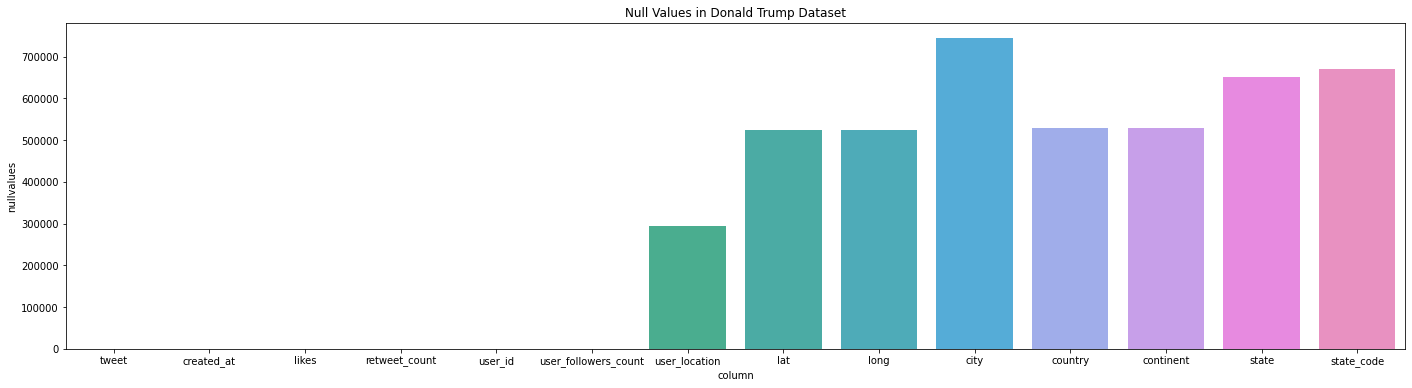

In [ ]:
#Plotting the null values to analyze the trump dataset
plt.figure(figsize=(24,6))

sns.barplot(x=col_null_values["column"], y=col_null_values["nullvalues"])

plt.title("Null Values in Donald Trump Dataset")

In [ ]:
#Observing the data types of all the columns for better insights to the dataset
trump_tweets.dtypes

tweet                    object
created_at               object
likes                    object
retweet_count           float64
user_id                  object
user_followers_count     object
user_location            object
lat                      object
long                     object
city                     object
country                  object
continent                object
state                    object
state_code               object
dtype: object

In [ ]:
#Cleaning the dataframe by setting proper data types of the respective columns
def clean_data_frame(dataframe):
    dataframe['likes'] = pd.to_numeric(dataframe['likes'], errors="coerce")
    dataframe['user_followers_count'] = pd.to_numeric(dataframe['user_followers_count'], errors="coerce")
    dataframe["likes"].fillna(dataframe["likes"].mean(), inplace=True)
    dataframe["retweet_count"].fillna(dataframe["retweet_count"].mean(), inplace=True)
    dataframe["user_followers_count"].fillna(dataframe["user_followers_count"].mean(), inplace=True)
    dataframe['created_at'] = pd.to_datetime(dataframe['created_at'], errors="coerce") 
    dataframe["created_at"] = dataframe["created_at"].dt.strftime('%m-%d')

In [ ]:
#Cleanign the data frame
clean_data_frame(trump_tweets)

In [ ]:
#Checking the number of empty rows in the tweet column of the dataset
np.sum(trump_tweets["tweet"].isnull())

14

In [ ]:
#Dropping all the rows which do not have a tweet
trump_tweets = trump_tweets.dropna(subset=['tweet'])

In [ ]:
#Checking the null values of all the columns after removing the rows with no tweets
check_col_null_values(trump_tweets)

tweet: null percent: 0.0 null values: 0/971073 value count: 971073/971073
created_at: null percent: 0.015858745943919766 null values: 154/971073 value count: 970919/971073
likes: null percent: 0.0 null values: 0/971073 value count: 971073/971073
retweet_count: null percent: 0.0 null values: 0/971073 value count: 971073/971073
user_id: null percent: 0.014828957246262639 null values: 144/971073 value count: 970929/971073
user_followers_count: null percent: 0.0 null values: 0/971073 value count: 971073/971073
user_location: null percent: 30.402863636410444 null values: 295234/971073 value count: 675839/971073
lat: null percent: 54.10211178768228 null values: 525371/971073 value count: 445702/971073
long: null percent: 54.10180285107299 null values: 525368/971073 value count: 445705/971073
city: null percent: 76.60526036662537 null values: 743893/971073 value count: 227180/971073
country: null percent: 54.40795903088645 null values: 528341/971073 value count: 442732/971073
continent: null 

,column,nullvalues
0,tweet,0
1,created_at,154
2,likes,0
3,retweet_count,0
4,user_id,144
5,user_followers_count,0
6,user_location,295234
7,lat,525371
8,long,525368
9,city,743893


In [ ]:
#Cleaning the dataset using the regex preprocessing as specified above
trump_tweets["tweet"] = trump_tweets["tweet"].apply(clean_tweet_text_regex)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
#Detecting the language of the tweets as we are only going to use English Tweets
trump_langs = trump_tweets["tweet"].apply(detect_lang)

In [ ]:
#List of all the languages of tweets for trump 
trump_langs.unique()

array(['SPANISH', 'Unknown', 'ENGLISH', 'FRENCH', 'TURKISH', 'FINNISH',
       'LATIN', 'ITALIAN', 'BOSNIAN', 'GERMAN', 'SCOTS', 'PORTUGUESE',
       'INDONESIAN', 'CATALAN', 'BASQUE', 'DUTCH', 'BRETON', 'DANISH',
       'KINYARWANDA', 'SWEDISH', 'POLISH', 'SERBIAN', 'CROATIAN',
       'SLOVAK', 'NORWEGIAN', 'SWAHILI', 'AFRIKAANS', 'TSWANA',
       'AZERBAIJANI', 'CZECH', 'MALAY', 'SOMALI', 'CORSICAN', 'OCCITAN',
       'ALBANIAN', 'FRISIAN', 'LINGALA', 'NORWEGIAN_N', 'MANX', 'WOLOF',
       'SCOTS_GAELIC', 'INTERLINGUE', 'HUNGARIAN', 'JAVANESE',
       'RHAETO_ROMANCE', 'GALICIAN', 'RUNDI', 'IRISH', 'ROMANIAN',
       'NAURU', 'X_PIG_LATIN', 'CEBUANO', 'GUARANI', 'ESPERANTO',
       'BISLAMA', 'LUXEMBOURGISH', 'TAGALOG', 'AFAR', 'SANSKRIT',
       'TURKMEN', 'HAUSA', 'SLOVENIAN', 'TATAR', 'UZBEK', 'SISWANT',
       'INTERLINGUA', 'SHONA', 'X_KLINGON', 'XHOSA', 'HAITIAN_CREOLE',
       'SESELWA', 'WELSH', 'OROMO', 'AYMARA', 'LITHUANIAN', 'GANDA',
       'SESOTHO', 'YORUBA', 'WARAY_PHIL

In [ ]:
#Adding a column in the context dataframe which specifies the language of the tweet. The purpose here is to use only the english language tweets
trump_tweets["Lang"] = trump_langs

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
#Creating a sub-data frame of tweets present only in english language
eng_tweet_trump = trump_tweets[trump_tweets["Lang"] == "ENGLISH"]

In [ ]:
#Clean the dataset using the stop words removal and lemmatization of tweets functions specifieds
eng_tweet_trump["tweet"] = clean_tweet_spacy(eng_tweet_trump, "tweet")

Tweets cleaning started
Tweets cleanned


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
#Creating a dataframe for tweets related to Joe Biden
joebiden_tweets = pd.read_csv("hashtag_joebiden.csv", engine="python")
joebiden_tweets.head()

,created_at,tweet_id,tweet,likes,retweet_count,source,user_id,user_name,user_screen_name,user_description,user_join_date,user_followers_count,user_location,lat,long,city,country,continent,state,state_code,collected_at
0,2020-10-15 00:00:01,1.316529221557252e+18,#Elecciones2020 | En #Florida: #JoeBiden dice ...,0.0,0.0,TweetDeck,360666534.0,El Sol Latino News,elsollatinonews,🌐 Noticias de interés para latinos de la costa...,2011-08-23 15:33:45,1860.0,"Philadelphia, PA / Miami, FL",25.77427,-80.19366,NaN,United States of America,North America,Florida,FL,2020-10-21 00:00:00
1,2020-10-15 00:00:18,1.31652929585929e+18,#HunterBiden #HunterBidenEmails #JoeBiden #Joe...,0.0,0.0,Twitter for iPad,809904438.0,Cheri A. 🇺🇸,Biloximeemaw,"Locked and loaded Meemaw. Love God, my family ...",2012-09-08 01:03:57,6628.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-10-21 00:00:00.517827283
2,2020-10-15 00:00:20,1.3165293050069524e+18,@IslandGirlPRV @BradBeauregardJ @MeidasTouch T...,0.0,0.0,Twitter Web App,3494182277.0,Flag Waver,Flag_Wavers,NaN,2015-08-30 19:38:21,1536.0,Golden Valley Arizona,46.3040364,-109.17143119999999,NaN,United States of America,North America,Montana,MT,2020-10-21 00:00:01.035654566
3,2020-10-15 00:00:21,1.3165293080815575e+18,@chrislongview Watching and setting dvr. Let’s...,0.0,0.0,Twitter for iPhone,8.242596012018524e+17,Michelle Ferg,MichelleFerg4,NaN,2017-01-25 14:16:17,27.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-10-21 00:00:01.553481849
4,2020-10-15 00:00:22,1.316529312741253e+18,#censorship #HunterBiden #Biden #BidenEmails #...,1.0,0.0,Twitter Web App,1.032806955356545e+18,the Gold State,theegoldstate,A Silicon Valley #independent #News #Media #St...,2018-08-24 01:49:01,390.0,"California, USA",36.7014631,-118.75599740000001,NaN,United States of America,North America,California,CA,2020-10-21 00:00:02.071309132


In [ ]:
#Checking the columns of the dataframe
joebiden_tweets = joebiden_tweets[columns]

In [ ]:
#Checking the null values in the dataframe 
joe_col_null_values = check_col_null_values(joebiden_tweets)

tweet: null percent: 0.010037666988815723 null values: 78/777073 value count: 776995/777073
created_at: null percent: 0.0 null values: 0/777073 value count: 777073/777073
likes: null percent: 0.020461398092585896 null values: 159/777073 value count: 776914/777073
retweet_count: null percent: 0.022906470820630753 null values: 178/777073 value count: 776895/777073
user_id: null percent: 0.023678599050539654 null values: 184/777073 value count: 776889/777073
user_followers_count: null percent: 0.024193351203812254 null values: 188/777073 value count: 776885/777073
user_location: null percent: 30.113901782715395 null values: 234007/777073 value count: 543066/777073
lat: null percent: 54.279198994174294 null values: 421789/777073 value count: 355284/777073
long: null percent: 54.279198994174294 null values: 421789/777073 value count: 355284/777073
city: null percent: 75.95219496752557 null values: 590204/777073 value count: 186869/777073
country: null percent: 54.47403268418797 null values:

Text(0.5, 1.0, 'Null Values in Joe Biden Dataset')

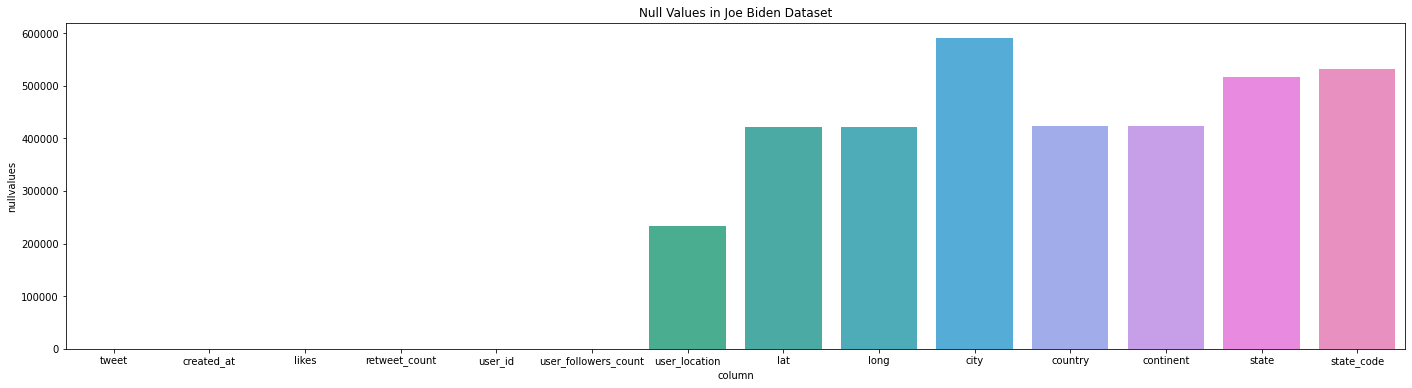

In [ ]:
#Plotting the null values to analyze the biden dataset
plt.figure(figsize=(24,6))

sns.barplot(x=joe_col_null_values["column"], y=joe_col_null_values["nullvalues"])
plt.title("Null Values in Joe Biden Dataset")

In [ ]:
#Observing the data types of all the columns for better insights to the dataset
joebiden_tweets.dtypes

tweet                    object
created_at               object
likes                    object
retweet_count           float64
user_id                  object
user_followers_count     object
user_location            object
lat                      object
long                     object
city                     object
country                  object
continent                object
state                    object
state_code               object
dtype: object

In [ ]:
#Cleanign the data frame by proper assignment of datatypes
clean_data_frame(joebiden_tweets)

In [ ]:
#Checking the number of empty rows in the tweet column of the dataset
np.sum(joebiden_tweets["tweet"].isnull())

78

In [ ]:
#Dropping all the rows which do not have a tweet
joebiden_tweets = joebiden_tweets.dropna(subset=['tweet'])

In [ ]:
#Cleaning the dataset using the regex preprocessing as specified above
joebiden_tweets["tweet"] = joebiden_tweets["tweet"].apply(clean_tweet_text_regex)

In [ ]:
#Detecting the language of the tweets as we are only going to use English Tweets
joe_langs = joebiden_tweets["tweet"].apply(detect_lang)

In [ ]:
#List of all the languages of tweets for biden
joe_langs.unique()

array(['SPANISH', 'Unknown', 'ENGLISH', 'BASQUE', 'TURKISH', 'LATIN',
       'BRETON', 'GERMAN', 'FRENCH', 'XHOSA', 'INDONESIAN', 'CATALAN',
       'POLISH', 'DUTCH', 'PORTUGUESE', 'ITALIAN', 'SWEDISH', 'SCOTS',
       'FINNISH', 'CROATIAN', 'NORWEGIAN', 'AFRIKAANS', 'LUXEMBOURGISH',
       'KINYARWANDA', 'ALBANIAN', 'X_PIG_LATIN', 'CZECH', 'DANISH',
       'BOSNIAN', 'MALAY', 'HUNGARIAN', 'NORWEGIAN_N', 'GALICIAN',
       'VOLAPUK', 'RUNDI', 'IRISH', 'CORSICAN', 'NAURU', 'ROMANIAN',
       'INTERLINGUA', 'BISLAMA', 'SERBIAN', 'NDEBELE', 'SHONA',
       'SANSKRIT', 'X_KLINGON', 'INTERLINGUE', 'SESOTHO', 'GUARANI',
       'SOMALI', 'ESPERANTO', 'TSWANA', 'HAITIAN_CREOLE', 'SWAHILI',
       'SISWANT', 'LINGALA', 'RHAETO_ROMANCE', 'GANDA', 'NYANJA',
       'OCCITAN', 'SLOVENIAN', 'HAUSA', 'MALAGASY', 'TATAR', 'FAROESE',
       'UZBEK', 'AZERBAIJANI', 'FRISIAN', 'ESTONIAN', 'SLOVAK',
       'MAURITIAN_CREOLE', 'LATVIAN', 'SAMOAN', 'VIETNAMESE', 'SESELWA',
       'HAWAIIAN', 'CEBUANO', 'TAG

In [ ]:
joe_langs.value_counts()

ENGLISH       526887
Unknown       118989
SPANISH        32578
FRENCH         22488
GERMAN         19271
               ...  
NYANJA             1
FAROESE            1
VIETNAMESE         1
IGBO               1
NDEBELE            1
Name: tweet, Length: 100, dtype: int64

In [ ]:
#Adding a column in the context dataframe which specifies the language of the tweet. The purpose here is to use only the english language tweets
joebiden_tweets["Lang"] = joe_langs

In [ ]:
#Creating a sub-data frame of tweets present only in english language
eng_joebiden_tweets = joebiden_tweets[joebiden_tweets["Lang"] == "ENGLISH"]

In [ ]:
#Clean the dataset using the stop words removal and lemmatization of tweets functions specifieds
eng_joebiden_tweets["tweet"] = clean_tweet_spacy(eng_joebiden_tweets, "tweet")

Tweets cleaning started
Tweets cleanned


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


# ***Exploratory Data Analysis***


# ***Analyzed Top 10 Languages in All Datasets***
I have only used English tweets in this project to analyze the sentiments.

In [ ]:
#Extracting the Languages for the training dataset
train_languages = labeled_data["Lang"].value_counts()

train_languages

ENGLISH        1517042
Unknown          74023
SCOTS             2179
INDONESIAN        1034
PORTUGUESE         825
                ...   
LINGALA              2
AZERBAIJANI          1
SANGO                1
SHONA                1
FIJIAN               1
Name: Lang, Length: 105, dtype: int64

In [ ]:
#Extracting the Languages for the trump dataset
trump_langs_value_count = trump_langs.value_counts()

trump_langs_value_count

ENGLISH     673207
Unknown     127332
SPANISH      41265
GERMAN       37115
FRENCH       31466
             ...  
MALAGASY         1
IGBO             1
FIJIAN           1
YORUBA           1
SAMOAN           1
Name: tweet, Length: 101, dtype: int64

In [ ]:
#Extracting the Languages for the biden dataset
joe_langs_count = joe_langs.value_counts()

joe_langs_count

ENGLISH       526887
Unknown       118989
SPANISH        32578
FRENCH         22488
GERMAN         19271
               ...  
NYANJA             1
FAROESE            1
VIETNAMESE         1
IGBO               1
NDEBELE            1
Name: tweet, Length: 100, dtype: int64

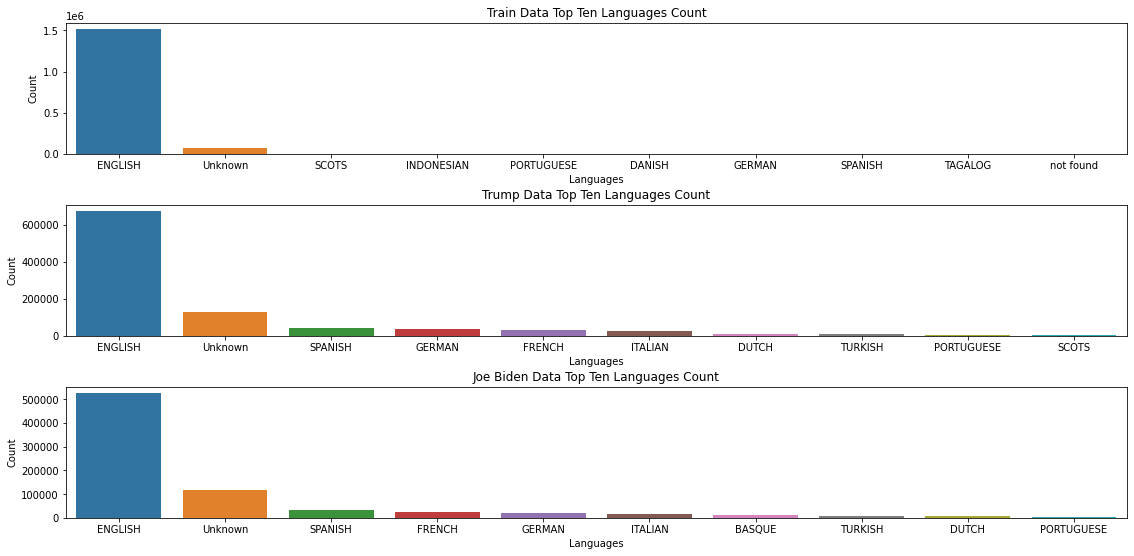

In [ ]:
#Creating a plot to analyze the top 10 languages for all of the three datasets
fig, axes = plt.subplots(nrows=3, figsize=(16, 8))

#plt.figure(figsize=(16,6))
fig.tight_layout(pad=3.0)
plt.setp(axes, xlabel="Languages", ylabel="Count")
axes[0].set_title("Train Data Top Ten Languages Count")
axes[1].set_title("Trump Data Top Ten Languages Count")
axes[2].set_title("Joe Biden Data Top Ten Languages Count")
sns.barplot(x=train_languages.index[:10], y=train_languages.values[:10], ax=axes[0])

sns.barplot(x=trump_langs_value_count.index[:10], y=trump_langs_value_count.values[:10], ax=axes[1])

sns.barplot(x=joe_langs_count.index[:10], y=joe_langs_count.values[:10], ax=axes[2])

# ***Analyzed Tweets, Likes and Retweets Count w.r.t. Date.***
First I have analyzed the count of tweets and likes for both the participants w.r.t. Date and according to graph Joe Biden Graph is increasing by time.

Now we have analyzed the count of retweets for both the participants w.r.t. Date and according to the graph Donald Trump retweets count is increasing by time.

In [ ]:
#Grouping the tweets of trump by created at instance to analyze the dataframes w.r.t date
trump_tweets_by_date = trump_tweets.groupby("created_at")

trump_tweets_count_by_date = trump_tweets_by_date.count()

trump_tweets_by_date_sum = trump_tweets_by_date.sum(numeric_only=True)


In [ ]:
#Grouping the tweets of biden by created at instance to analyze the dataframes w.r.t date
joe_tweets_by_date = joebiden_tweets.groupby("created_at")

joe_tweets_count_by_date = joe_tweets_by_date.count()

joe_tweets_by_date_sum = joe_tweets_by_date.sum(numeric_only=True)


In [ ]:
#Create a Dataframe which contains the tweets count of both the candidates
tweet_df = pd.DataFrame(columns=["Date", "Trump Tweets Count", "Joe Biden Tweets Count"])
tweet_df["Date"] = trump_tweets_count_by_date.index
tweet_df["Trump Tweets Count"] = list(trump_tweets_count_by_date.tweet)
tweet_df["Joe Biden Tweets Count"] = list(joe_tweets_count_by_date.tweet)

tweet_df.set_index("Date", inplace=True)


Text(0, 0.5, 'Tweet Counts')

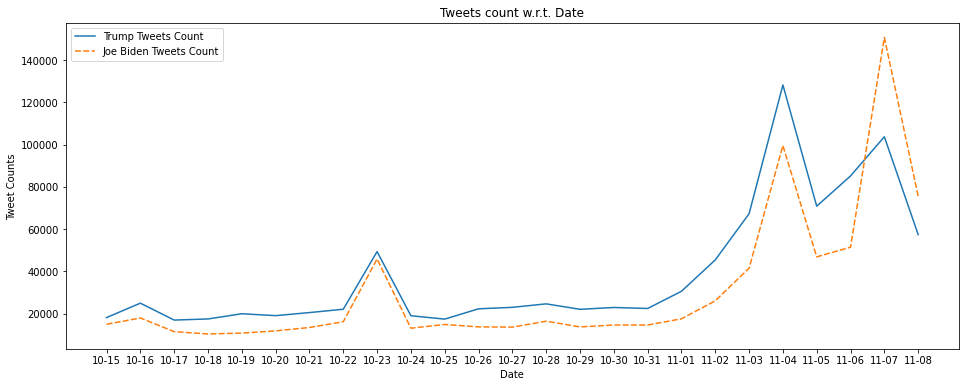

In [ ]:
#Plot the trend to analyze the trend according to the date
plt.figure(figsize=(16,6))

sns.lineplot(data=tweet_df)
plt.title("Tweets count w.r.t. Date")
plt.ylabel("Tweet Counts")

In [ ]:
#Create a Dataframe which contains the likes sum of both the candidates wrt date
likes_df = pd.DataFrame(columns=["Date", "Trump Likes", "Joe Biden Likes"])
likes_df["Date"] = trump_tweets_count_by_date.index
likes_df["Trump Likes"] = list(trump_tweets_by_date_sum.likes)
likes_df["Joe Biden Likes"] = list(joe_tweets_by_date_sum.likes)

likes_df.set_index("Date", inplace=True)

Text(0, 0.5, 'Likes Counts')

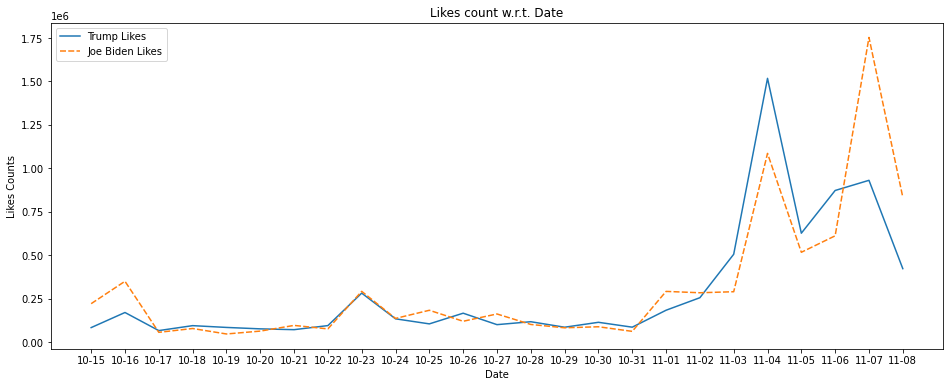

In [ ]:
#Plot the trend to analyze the trend according to the date
plt.figure(figsize=(16,6))

sns.lineplot(data=likes_df)

plt.title("Likes count w.r.t. Date")
plt.ylabel("Likes Counts")

In [ ]:
#Create a Dataframe which contains the retweets sum of both the candidates wrt date
retweet_count_df = pd.DataFrame(columns=["Date", "Trump Retweet Count", "Joe Biden Retweet Count"])
retweet_count_df["Date"] = trump_tweets_count_by_date.index
retweet_count_df["Trump Retweet Count"] = list(trump_tweets_by_date_sum.retweet_count)
retweet_count_df["Joe Biden Retweet Count"] = list(joe_tweets_by_date_sum.retweet_count)

retweet_count_df.set_index("Date", inplace=True)

Text(0, 0.5, 'Retweets Counts')

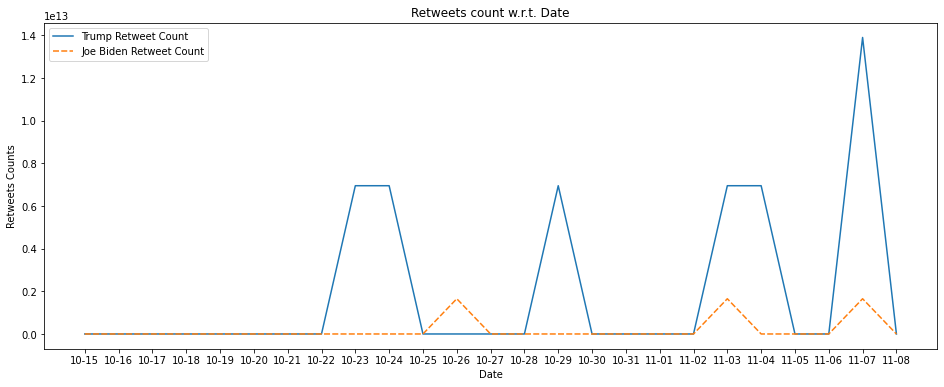

In [ ]:
#Plot the trend to analyze the trend according to the date
plt.figure(figsize=(16,6))

sns.lineplot(data=retweet_count_df)

plt.title("Retweets count w.r.t. Date")
plt.ylabel("Retweets Counts")

# ***Word Cloud Of Donald Trump and Joe Biden Tweets***

Text(0.5, 1.0, 'Trump Tweets Word Cloud')

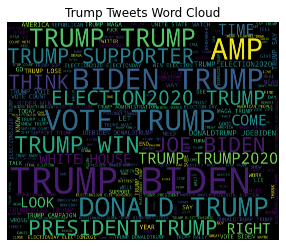

In [ ]:
#Creating a wordcloud of the trump dataset to visually analyze the abundant presence of the words in dataframe
stopwords = set(STOPWORDS) 
wordcloud = WordCloud(width=5000, height=4000,stopwords=stopwords,random_state = 2016).generate(" ".join([i for i in eng_tweet_trump['tweet'].str.upper()]))
plt.imshow(wordcloud)
plt.axis("off")
plt.title("Trump Tweets Word Cloud")


Text(0.5, 1.0, 'Joe Biden Tweets Word Cloud')

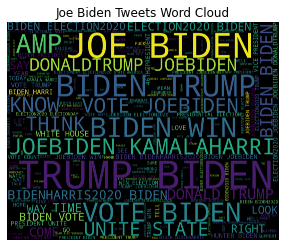

In [ ]:
#Creating a wordcloud of the biden dataset to visually analyze the abundant presence of the words in dataframe
stopwords = set(STOPWORDS)
wordcloud = WordCloud(width=5000, height=4000,stopwords=stopwords,random_state = 2016).generate(" ".join([i for i in eng_joebiden_tweets['tweet'].str.upper()]))
plt.imshow(wordcloud)
plt.axis("off")
plt.title("Joe Biden Tweets Word Cloud")

# ***Building a Model***
First of all I have extracted features from tweets using HashVectorizer and then I have splitted our training data in 80-20 ratio. I have tried different algorithms but due to huge dataset including huge number of features and rows, very limited number of algorithms worked reasonable time. In Others like Random Forest, SVM I waited for a very long time but it did not complete training. Only Naive Bayessian (GaussianNB) and LogisticRegression worked in a reasonable time. Among these two LogisticRegression had given us 77% of accuracy and Naive Bayessian gave 50% of accuracy. So I have selected LogisticRegression. Once our model is trainned I used this model to find the sentiments of the tweets of both the participants.

In [ ]:
#Training the model by creating a pipeling of hashing vectorizer and logisiticRegressor
def train_model(train_data, targets):
    X_train, X_test, Y_train, Y_test = train_test_split(train_data, targets, test_size=0.2)

    model = Pipeline([('vect', HashingVectorizer()),
                      ('logreg', LogisticRegression(max_iter=1000, solver="saga")),
              ])
    model.fit(X_train, Y_train)

    return model, X_test, Y_test

In [ ]:
#Evaluate the test data according to the specified metrics
def check_model_metrics(model, test_data, test_targets):
    y_pred = model.predict(test_data)

    print("ACCURACY:")
    print(metrics.accuracy_score(test_targets, y_pred)*100)

    print("\nCONFUSSION MATRIX")
    print(confusion_matrix(test_targets, y_pred))

    print("\nCLASSIFICATION REPORT")
    print(classification_report(test_targets, y_pred))

In [ ]:
#Specify the training dataset
train_data = eng_train_data['text']

In [ ]:
#Specify the target dataset
targets = eng_train_data["label"]

In [ ]:
#Train the model and extract the test dataset
model, x_test, y_test = train_model(train_data, targets)

In [ ]:
#Evaluate the performance of the model on the test dataset
check_model_metrics(model, x_test, y_test)

ACCURACY:
77.16547630426255

CONFUSSION MATRIX
[[115804  37219]
 [ 32063 118323]]

CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.78      0.76      0.77    153023
           4       0.76      0.79      0.77    150386

    accuracy                           0.77    303409
   macro avg       0.77      0.77      0.77    303409
weighted avg       0.77      0.77      0.77    303409



In [ ]:
#Extract sentiments from the polarities specifying the tweets as positive, negative or neutral
def get_sentiments(model, data, level_of_significance):
    sentiments=[]
    polarity = []
    prediction_prob = model.predict_proba(data)

    for prob in prediction_prob:
        dif = prob[1] - prob[0]
        polarity.append(prob[1])
        if dif >= -level_of_significance and dif <= level_of_significance:
            sentiments.append("Neutral")
        elif dif > level_of_significance:
            sentiments.append("Positive")
        else:
            sentiments.append("Negative")
            
    return sentiments, polarity

In [ ]:
#Extract the trump tweets data
trump_tweets_data = eng_tweet_trump["tweet"]

In [ ]:
#Extract the sentiments for the trump dataset
trump_sentiments, trump_polarity = get_sentiments(model, trump_tweets_data, 0.1)

In [ ]:
#Extract the biden tweets data
joe_tweets_data = eng_joebiden_tweets["tweet"]

In [ ]:
#Extract the sentiments for the biden dataset
joe_sentiments, joe_polarity = get_sentiments(model, joe_tweets_data, 0.1)

# ***Presentation Of Final Results***
After sentiments of Donald Trump and Joe Biden Tweets are determined, I have shown that Joe Biden had won the elections 2020 according to the sentiments in tweets also. 

1) First I have analyzed sentiments counts w.r.t. Country and states of both the participants. 

2) Then I have analyzed Average polarity w.r.t. Date of both the participants. 

3) Then I have analyzed Sentiment count w.r.t. Date of both the participants. 

4) Then I have analyzed likes of the sentiments w.r.t. Date of both the participants. 

5) Then I have analyzed Sentiment retweets w.r.t. Date of both the participants. 

6) Lastly I have shown the pie chart of the percentage of positive, neutral and negative tweets of both the participants.

In [ ]:
#Evaluation of the sentiments for trump
pd.Series(trump_sentiments).value_counts(normalize=True)

Positive    0.463165
Negative    0.357952
Neutral     0.178883
dtype: float64

In [ ]:
#Evaluation of the sentiments for biden
pd.Series(joe_sentiments).value_counts(normalize=True)

Positive    0.635706
Negative    0.225654
Neutral     0.138641
dtype: float64

In [ ]:
#Creation of sentiments and polarity columns for trump and biden in their respective dataframes
eng_tweet_trump["sentiments"] = trump_sentiments
eng_tweet_trump["polarity"] = trump_polarity

eng_joebiden_tweets["sentiments"] = joe_sentiments
eng_joebiden_tweets["polarity"] = joe_polarity

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

In [ ]:
#Analysis of sentiments counts w.r.t. Country and states of trump

frame = (eng_tweet_trump["country"].value_counts(normalize=True)*100).to_frame()

trump_countries = frame[frame["country"] >= 1].index

trump_countrywise_tweets = eng_tweet_trump[eng_tweet_trump["country"].isin(trump_countries)][["country","sentiments","tweet"]]

#Add the number of positive, neutral or negative tweet counts according to the country
df_trump_countrywise_sentiments = trump_countrywise_tweets.groupby(["country", "sentiments"]).count().unstack(level=1)

df_trump_countrywise_sentiments.columns = ["Negative Tweets Count", "Neutral Tweets Count", "Positive Tweets Count"]

#Calculate the percentage of share of respective countries in the tweet counts

df_trump_countrywise_sentiments["Positive Tweets Count %"] = (df_trump_countrywise_sentiments["Positive Tweets Count"] / (df_trump_countrywise_sentiments["Positive Tweets Count"] + df_trump_countrywise_sentiments["Neutral Tweets Count"]+df_trump_countrywise_sentiments["Negative Tweets Count"]))*100

df_trump_countrywise_sentiments["Neutral Tweets Count %"] = (df_trump_countrywise_sentiments["Neutral Tweets Count"] / (df_trump_countrywise_sentiments["Positive Tweets Count"] + df_trump_countrywise_sentiments["Neutral Tweets Count"]+df_trump_countrywise_sentiments["Negative Tweets Count"]))*100

df_trump_countrywise_sentiments["Negative Tweets Count %"] = (df_trump_countrywise_sentiments["Negative Tweets Count"] / (df_trump_countrywise_sentiments["Positive Tweets Count"] + df_trump_countrywise_sentiments["Neutral Tweets Count"]+ df_trump_countrywise_sentiments["Negative Tweets Count"]))*100



In [ ]:
#Analysis of sentiments counts w.r.t. Country and states of biden

frame = (eng_joebiden_tweets["country"].value_counts(normalize=True)*100).to_frame()

joe_countries = frame[frame["country"] >= 1].index

joe_countrywise_tweets = eng_joebiden_tweets[eng_joebiden_tweets["country"].isin(joe_countries)][["country","sentiments","tweet"]]

#Add the number of positive, neutral or negative tweet counts according to the country
df_joe_countrywise_sentiments = joe_countrywise_tweets.groupby(["country", "sentiments"]).count().unstack(level=1)

df_joe_countrywise_sentiments.columns = ["Negative Tweets Count", "Neutral Tweets Count", "Positive Tweets Count"]

#Calculate the percentage of share of respective countries in the tweet counts

df_joe_countrywise_sentiments["Positive Tweets Count %"] = (df_joe_countrywise_sentiments["Positive Tweets Count"] / (df_joe_countrywise_sentiments["Positive Tweets Count"] +df_joe_countrywise_sentiments["Neutral Tweets Count"]+df_joe_countrywise_sentiments["Negative Tweets Count"]))*100

df_joe_countrywise_sentiments["Neutral Tweets Count %"] = (df_joe_countrywise_sentiments["Neutral Tweets Count"] / (df_joe_countrywise_sentiments["Positive Tweets Count"] +df_joe_countrywise_sentiments["Neutral Tweets Count"]+df_joe_countrywise_sentiments["Negative Tweets Count"]))*100

df_joe_countrywise_sentiments["Negative Tweets Count %"] = (df_joe_countrywise_sentiments["Negative Tweets Count"] / (df_joe_countrywise_sentiments["Positive Tweets Count"] +df_joe_countrywise_sentiments["Neutral Tweets Count"]+df_joe_countrywise_sentiments["Negative Tweets Count"]))*100



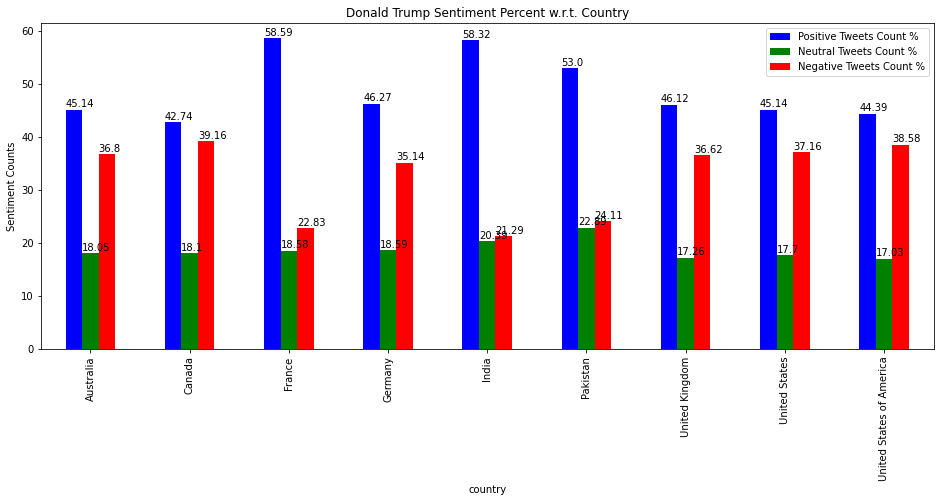

In [ ]:
#Plot the graph for trump to analyze the sentiments wrt to the country
plot = df_trump_countrywise_sentiments[["Positive Tweets Count %", "Neutral Tweets Count %", "Negative Tweets Count %"]].plot(kind="bar",figsize=(16,6),color=["blue","Green","red"])

plt.title("Donald Trump Sentiment Percent w.r.t. Country")
plt.ylabel("Sentiment Counts")
for p in plot.patches:
  plot.annotate(str(p.get_height().round(decimals=2)), (p.get_x(), p.get_height()+0.5 ))

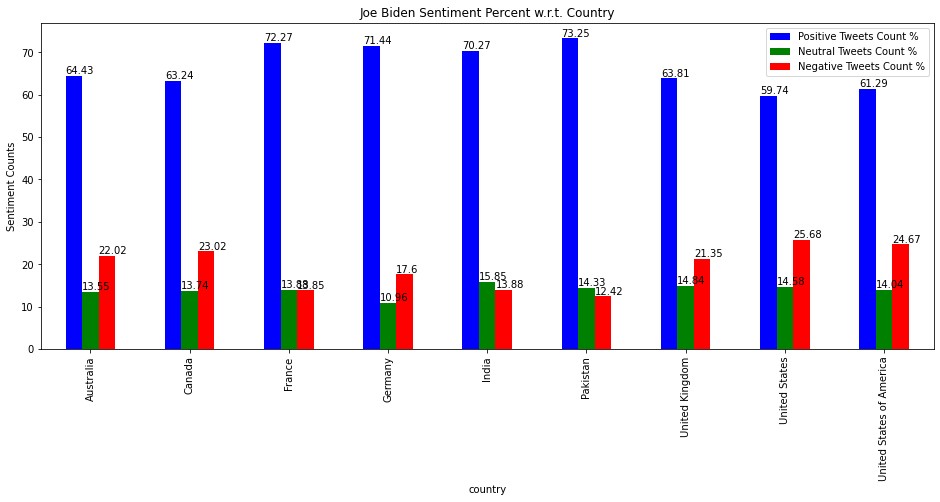

In [ ]:
#Plot the graph for biden to analyze the sentiments wrt to the country
plot = df_joe_countrywise_sentiments[["Positive Tweets Count %", "Neutral Tweets Count %", "Negative Tweets Count %"]].plot(kind="bar",figsize=(16,6),color=["blue","Green","red"])
plt.title("Joe Biden Sentiment Percent w.r.t. Country")
plt.ylabel("Sentiment Counts")

for p in plot.patches:
  plot.annotate(str(p.get_height().round(decimals=2)), (p.get_x(), p.get_height()+0.5 ))

Analysis of Average Polarity in United States wrt states for both the candidates

In [ ]:
#Extract datasets for both the candidates containing tweets only from the USA
trump_US_tweets = pd.concat([eng_tweet_trump[eng_tweet_trump["country"] == "United States of America"], eng_tweet_trump[eng_tweet_trump["country"] == "United States"]])

joe_US_tweets = pd.concat([eng_joebiden_tweets[eng_joebiden_tweets["country"] == "United States of America"], eng_joebiden_tweets[eng_joebiden_tweets["country"] == "United States"]])

In [ ]:
#Analysis of sentiments counts w.r.t. Country and states of trump

frame = (trump_US_tweets["state"].value_counts(normalize=True)*100).to_frame()
trump_states = frame[frame["state"] >= 1].index

trump_US_tweets = trump_US_tweets[trump_US_tweets["state"].isin(trump_states)]

#Add the number of positive, neutral or negative tweet counts according to the state
df_trump_statewise_sentiments = trump_US_tweets[["state","sentiments","tweet"]].groupby(["state", "sentiments"]).count().unstack(level=1)


df_trump_statewise_sentiments.columns = ["Negative Tweets Count", "Neutral Tweets Count", "Positive Tweets Count"]

#Calculate the percentage of share of respective countries in the tweet counts

df_trump_statewise_sentiments["Positive Tweets Count %"] = (df_trump_statewise_sentiments["Positive Tweets Count"] / (df_trump_statewise_sentiments["Positive Tweets Count"] + df_trump_statewise_sentiments["Neutral Tweets Count"]+df_trump_statewise_sentiments["Negative Tweets Count"]))*100

df_trump_statewise_sentiments["Neutral Tweets Count %"] = (df_trump_statewise_sentiments["Neutral Tweets Count"] / (df_trump_statewise_sentiments["Positive Tweets Count"] + df_trump_statewise_sentiments["Neutral Tweets Count"]+df_trump_statewise_sentiments["Negative Tweets Count"]))*100

df_trump_statewise_sentiments["Negative Tweets Count %"] = (df_trump_statewise_sentiments["Negative Tweets Count"] / (df_trump_statewise_sentiments["Positive Tweets Count"] + df_trump_statewise_sentiments["Neutral Tweets Count"]+ df_trump_statewise_sentiments["Negative Tweets Count"]))*100


In [ ]:
#Analysis of sentiments counts w.r.t. Country and states of biden

frame = (joe_US_tweets["state"].value_counts(normalize=True)*100).to_frame()

joe_states = frame[frame["state"] >= 1].index

joe_US_tweets = joe_US_tweets[joe_US_tweets["state"].isin(joe_states)]

#Add the number of positive, neutral or negative tweet counts according to the state

df_joe_statewise_sentiments = joe_US_tweets[["state","sentiments","tweet"]].groupby(["state", "sentiments"]).count().unstack(level=1)

df_joe_statewise_sentiments.columns = ["Negative Tweets Count", "Neutral Tweets Count", "Positive Tweets Count"]

#Calculate the percentage of share of respective countries in the tweet counts

df_joe_statewise_sentiments["Positive Tweets Count %"] = (df_joe_statewise_sentiments["Positive Tweets Count"] / (df_joe_statewise_sentiments["Positive Tweets Count"] +df_joe_statewise_sentiments["Neutral Tweets Count"]+df_joe_statewise_sentiments["Negative Tweets Count"]))*100

df_joe_statewise_sentiments["Neutral Tweets Count %"] = (df_joe_statewise_sentiments["Neutral Tweets Count"] / (df_joe_statewise_sentiments["Positive Tweets Count"] +df_joe_statewise_sentiments["Neutral Tweets Count"]+df_joe_statewise_sentiments["Negative Tweets Count"]))*100

df_joe_statewise_sentiments["Negative Tweets Count %"] = (df_joe_statewise_sentiments["Negative Tweets Count"] / (df_joe_statewise_sentiments["Positive Tweets Count"] +df_joe_statewise_sentiments["Neutral Tweets Count"]+df_joe_statewise_sentiments["Negative Tweets Count"]))*100




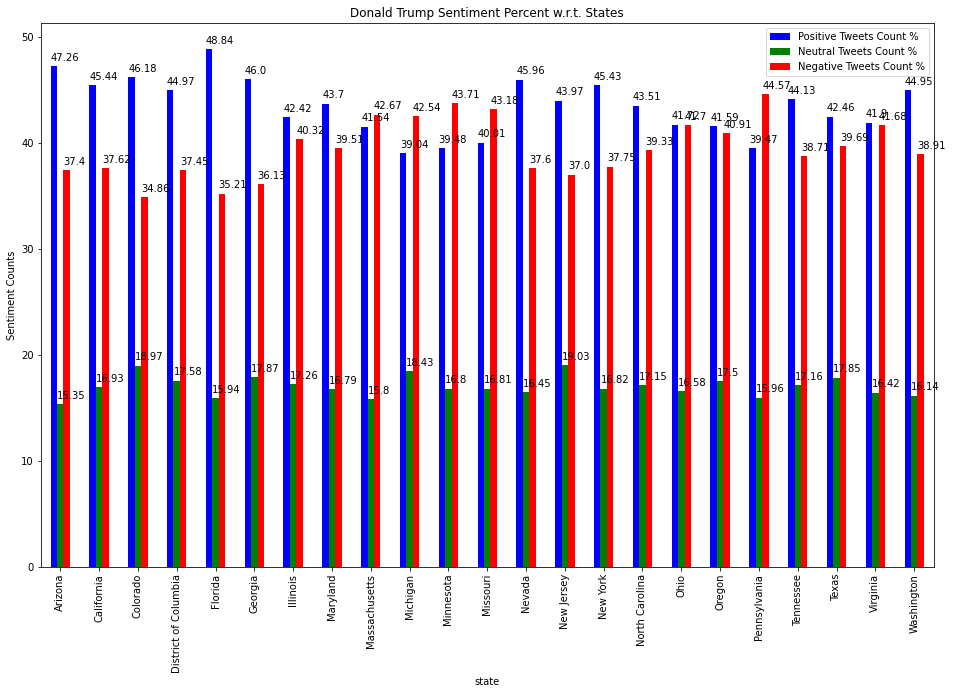

In [ ]:
#Plot the graph for trump to analyze the sentiments wrt to the state
plot = df_trump_statewise_sentiments[["Positive Tweets Count %", "Neutral Tweets Count %", "Negative Tweets Count %"]].plot(kind="bar",figsize=(16,10),color=["blue","Green","red"])

plt.title("Donald Trump Sentiment Percent w.r.t. States")
plt.ylabel("Sentiment Counts")

for p in plot.patches:
  plot.annotate(str(p.get_height().round(decimals=2)), (p.get_x(), p.get_height()+0.5 ))

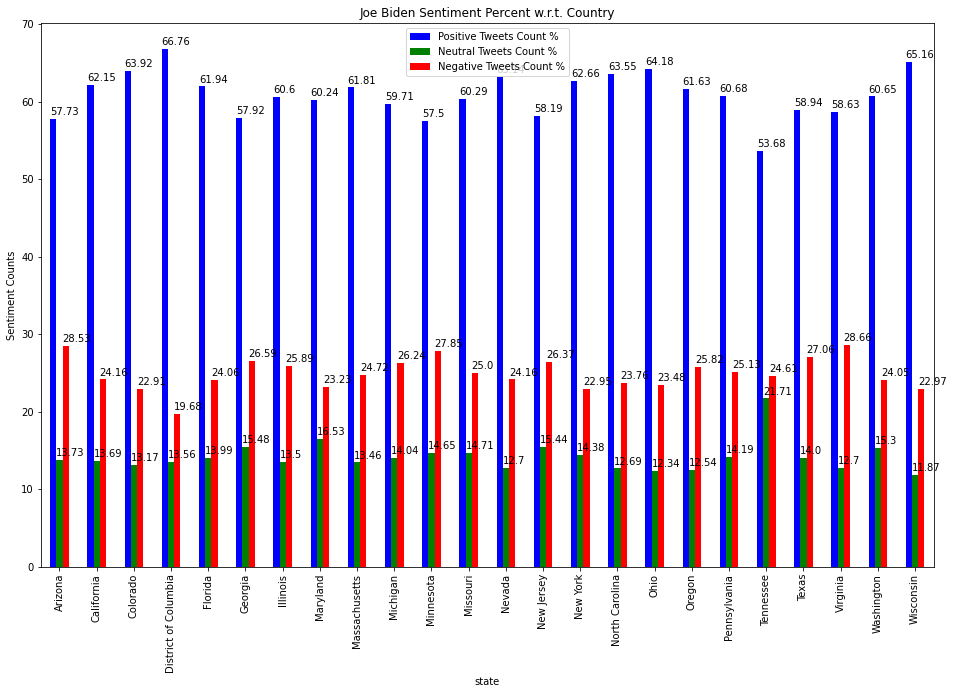

In [ ]:
#Plot the graph for biden to analyze the sentiments wrt to the state
plot = df_joe_statewise_sentiments[["Positive Tweets Count %", "Neutral Tweets Count %", "Negative Tweets Count %"]].plot(kind="bar",figsize=(16,10),color=["blue","Green","red"])

plt.title("Joe Biden Sentiment Percent w.r.t. Country")
plt.ylabel("Sentiment Counts")

for p in plot.patches:
  plot.annotate(str(p.get_height().round(decimals=2)), (p.get_x(), p.get_height()+0.5 ))

Analysis of the average polarity according to the date of the creation of tweets

In [ ]:
#Group according to the date while aggreagating using mean of a specified day
trump_groupby_date_mean = trump_US_tweets.groupby("created_at").mean()

joe_groupby_date_mean = joe_US_tweets.groupby("created_at").mean()

In [ ]:
#Create a new dataframe to assign the date wise polarity of both the candidates
datewise_polarity = pd.DataFrame(columns=["Date", "Trump Polarity", "Joe Polarity"])
dates = trump_groupby_date_mean.index
datewise_polarity["Date"] = dates
datewise_polarity["Trump Polarity"] = list(trump_groupby_date_mean.polarity)
datewise_polarity["Joe Polarity"] =list(joe_groupby_date_mean.polarity)

datewise_polarity.set_index("Date", inplace=True)

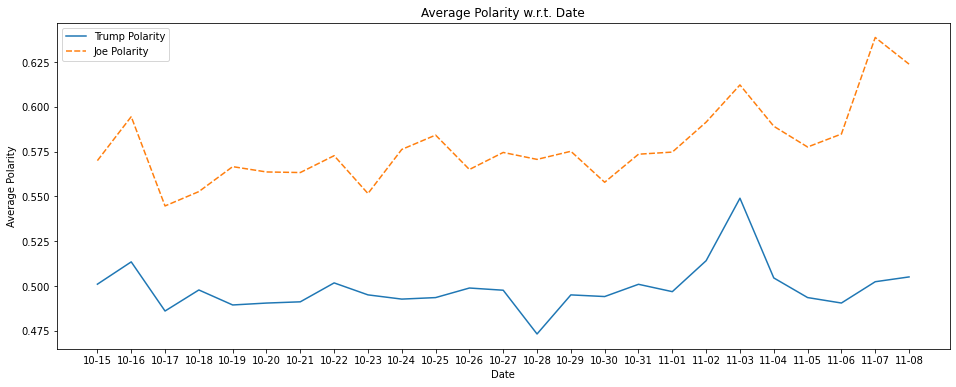

In [ ]:
#Plot the graph to analyze the data

plt.figure(figsize=(16,6))

plt.title("Average Polarity w.r.t. Date")
plt.ylabel("Average Polarity")

sns.lineplot(data=datewise_polarity)

Analysis of the Sentiments according to the date of the creation of tweets

In [ ]:
#Grouping the data according to the sentiments and creation date of tweets

df_trump_datewise_sentiments = trump_US_tweets[["created_at","sentiments","tweet"]].groupby(["created_at","sentiments"]).count().unstack(level=1)
df_trump_datewise_sentiments.columns = ["Negative Tweets Count", "Neutral Tweets Count", "Positive Tweets Count"]

df_joe_datewise_sentiments = joe_US_tweets[["created_at","sentiments","tweet"]].groupby(["created_at","sentiments"]).count().unstack(level=1)
df_joe_datewise_sentiments.columns = ["Negative Tweets Count", "Neutral Tweets Count", "Positive Tweets Count"]


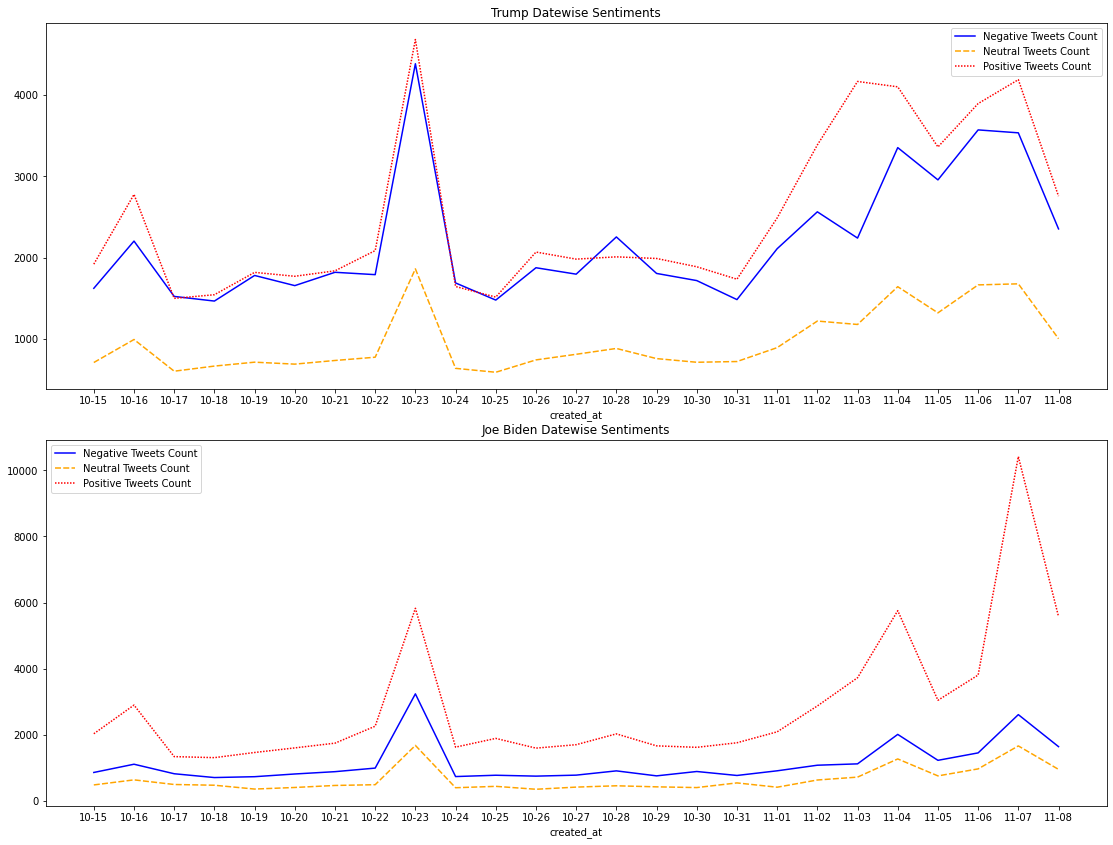

In [ ]:
#Plot the datewise sentiment analysis

fig, axes = plt.subplots(nrows=2, figsize=(16, 12))

fig.tight_layout(pad=3.0)
axes[0].set_title("Trump Datewise Sentiments")
axes[1].set_title("Joe Biden Datewise Sentiments")

sns.lineplot(data=df_trump_datewise_sentiments,ax=axes[0], palette=["blue","orange", "red"])
sns.lineplot(data=df_joe_datewise_sentiments,ax=axes[1], palette=["blue","orange", "red"])

Analysis of likes with respect to the date and sentiments

In [ ]:
#Grouping the data according to the creation date of tweets and likes of tweets

df_trump_datewise_sentiments_likes = trump_US_tweets[["created_at","sentiments","likes"]].groupby(["created_at","sentiments"]).sum().unstack(level=1)
df_trump_datewise_sentiments_likes.columns = [ "Negative  Tweets Like", "Neutral Tweets Like", "Positive Tweets Like"]

df_joe_datewise_sentiments_likes = joe_US_tweets[["created_at","sentiments", "likes"]].groupby(["created_at","sentiments"]).sum().unstack(level=1)
df_joe_datewise_sentiments_likes.columns = ["Negative  Tweets Like", "Neutral Tweets Like", "Positive Tweets Like"]

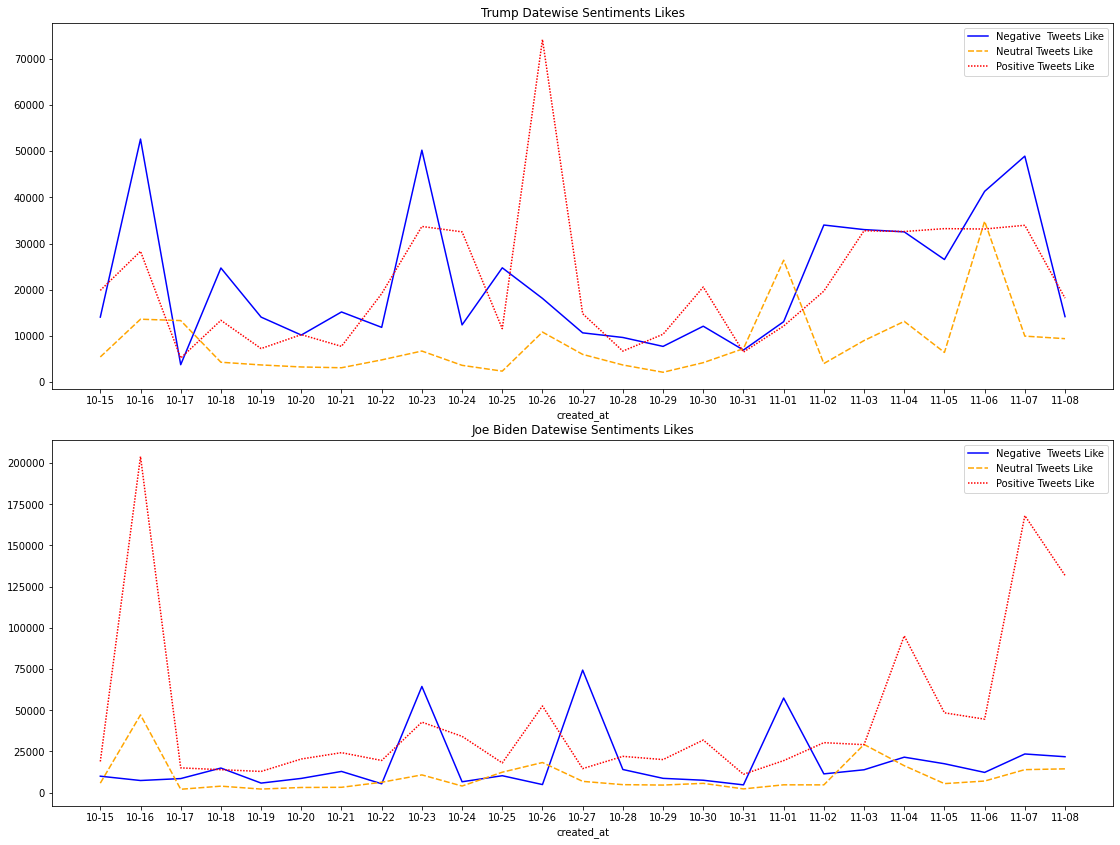

In [ ]:
#Plot the datewise likes on sentiment analysis
fig, axes = plt.subplots(nrows=2, figsize=(16, 12))

fig.tight_layout(pad=3.0)
axes[0].set_title("Trump Datewise Sentiments Likes")
axes[1].set_title("Joe Biden Datewise Sentiments Likes")

sns.lineplot(data=df_trump_datewise_sentiments_likes,ax=axes[0], palette=["blue","orange", "red"])
sns.lineplot(data=df_joe_datewise_sentiments_likes,ax=axes[1], palette=["blue","orange", "red"])

Now, I have analyzed Sentiment retweets w.r.t. Date of both the participants

In [ ]:
#Grouping the data according to the sentiments and creation date of tweets

df_trump_datewise_sentiments_retweets = trump_US_tweets[["created_at","sentiments","retweet_count"]].groupby(["created_at","sentiments"]).sum().unstack(level=1)
df_trump_datewise_sentiments_retweets.columns = [ "Negative Tweets Retweets", "Neutral Tweets Retweets", "Positive Tweets Retweets"]

df_joe_datewise_sentiments_retweets = joe_US_tweets[["created_at","sentiments", "retweet_count"]].groupby(["created_at","sentiments"]).sum().unstack(level=1)
df_joe_datewise_sentiments_retweets.columns = ["Negative Tweets Retweets", "Neutral Tweets Retweets", "Positive Tweets Retweets"]

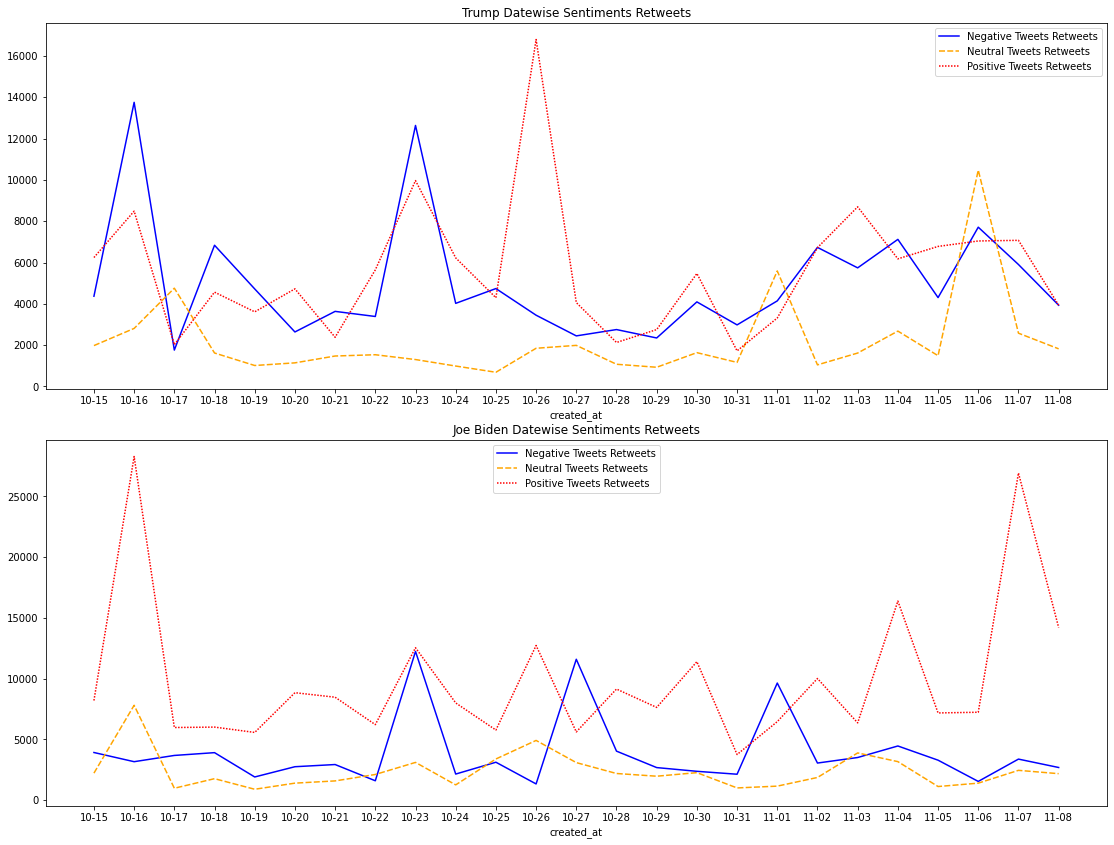

In [ ]:
#Plot the retweets on sentiment analysis
fig, axes = plt.subplots(nrows=2, figsize=(16, 12))

fig.tight_layout(pad=3.0)
axes[0].set_title("Trump Datewise Sentiments Retweets")
axes[1].set_title("Joe Biden Datewise Sentiments Retweets")

sns.lineplot(data=df_trump_datewise_sentiments_retweets,ax=axes[0], palette=["blue","orange", "red"])
sns.lineplot(data=df_joe_datewise_sentiments_retweets,ax=axes[1], palette=["blue","orange", "red"])

Plotting the pie-chart of the sentiments for both the candidates

([<matplotlib.patches.Wedge at 0x7f631588c860>,
 [Text(-0.475563677650144, 1.047062170312666, 'Positive'),
  Text(-0.010142925034175163, -1.0999532358567574, 'Negative'),
  Text(0.9973007309846775, -0.4641026308667384, 'Neutral')],
 [Text(-0.2274434980065906, 0.5007688640625793, '63.6%'),
  Text(-0.004610420470079619, -0.4999787435712533, '22.6%'),
  Text(0.4533185140839443, -0.2109557413030629, '13.9%')])

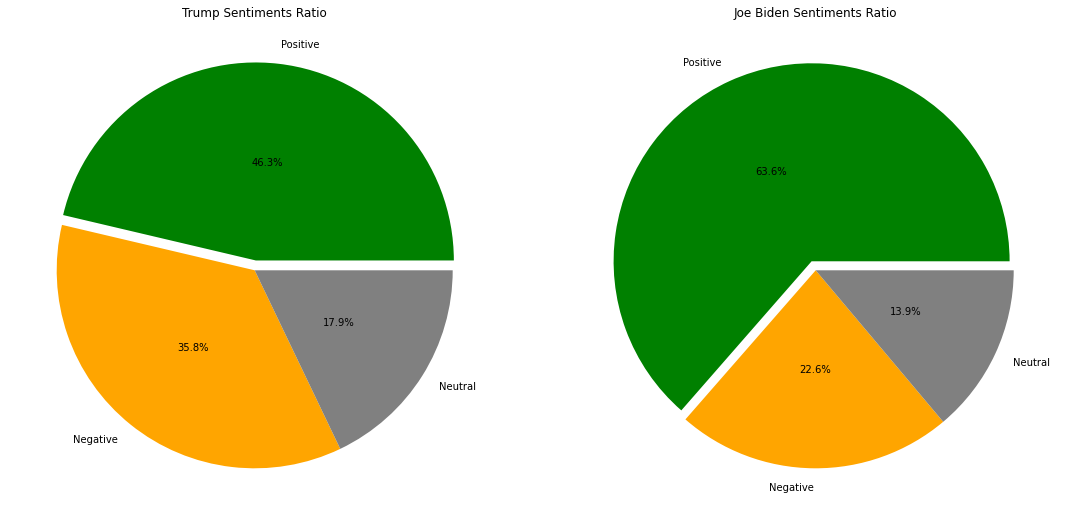

In [ ]:
#Plotting the sentiment pie-charts for both the candidates
fig, axes = plt.subplots(ncols=2, figsize=(16, 8))

fig.tight_layout(pad=3.0)
axes[0].set_title("Trump Sentiments Ratio")
axes[1].set_title("Joe Biden Sentiments Ratio")

trump_sentiments_values = eng_tweet_trump["sentiments"].value_counts()
joe_sentiments_values = eng_joebiden_tweets["sentiments"].value_counts()

axes[0].pie(x=trump_sentiments_values.values, autopct="%.1f%%", explode=[0.05,0, 0], colors=["green","orange","gray"],labels=trump_sentiments_values.index, pctdistance=0.5)
axes[1].pie(x=joe_sentiments_values.values, autopct="%.1f%%", explode=[0.05,0, 0], colors=["green","orange","gray"],labels=joe_sentiments_values.index, pctdistance=0.5)


# ***Hypothesis Testing***

# ***First Hypothesis***
H0 = Average polarity of Joe Biden is greater than overall average polarity.

Ha = Average polarity of Joe Biden is lesser than overall average polarity.

In [ ]:
 #Creating a dataframe concatinating polarities of both both the candidates
 all_polarity = pd.concat([eng_tweet_trump["polarity"], eng_joebiden_tweets["polarity"]])

In [ ]:
#Take a statistical sample to test the hypothesis
sample = eng_joebiden_tweets["polarity"].sample(n=50)

In [ ]:
#Find the sample mean, population mean and standard variance of the population 
x_ = sample.mean()
mio = all_polarity.mean()
sigma =all_polarity.std()
n=50

print("sample mean: ",x_, ", population mean: ", mio,", sigma: ", sigma, ", n: ", n)

sample mean:  0.5957151344734061 , population mean:  0.5470960017131273 , sigma:  0.20611902868163526 , n:  50


In [ ]:
#Calculate the z-value for the test
z_calc = (x_ - mio)/(sigma/math.sqrt(n))
print("Z calculated value is: ", z_calc)

Z calculated value is:  1.6679158004039831




---


Alpha = 0.05
Z_tabular = 1.65

As,

***Z_calc < Z_tabular***

So H0 is accepted and Average polarity of Joe Biden is greater than overall average polarity.

---



# ***Second Hypothesis***
Ho = Sentiments of Joe Biden is dependent or related to states

Ha = Sentiments of Joe Biden is Independent or not related to states

In [ ]:
#Compute a simple cross tabulation of both the features
chiObservedData = pd.crosstab(joe_US_tweets["sentiments"], joe_US_tweets["state"])

In [ ]:
chiObservedData

state,Arizona,California,Colorado,District of Columbia,Florida,Georgia,Illinois,Maryland,Massachusetts,Michigan,Minnesota,Missouri,Nevada,New Jersey,New York,North Carolina,Ohio,Oregon,Pennsylvania,Tennessee,Texas,Virginia,Washington,Wisconsin
sentiments,,,,,,,,,,,,,,,,,,,,,,,,
Negative,777,5362,534,1096,2536,742,1250,423,764,697,403,379,470,898,4107,631,784,525,1167,425,3328,571,448,325
Neutral,374,3040,307,755,1475,432,652,301,416,373,212,223,247,526,2574,337,412,255,659,375,1722,253,285,168
Positive,1572,13796,1490,3718,6529,1616,2926,1097,1910,1586,832,914,1228,1982,11213,1688,2143,1253,2818,927,7248,1168,1130,922


In [ ]:
#Chi-square test of independence of variables in a contingency table. 
#chi2float = The test statistic.
#pfloat = The p-value of the test
#dofint = Degrees of freedom
#expectedndarray = same shape as observed The expected frequencies, based on the marginal sums of the table.

stat, p, ddof, expected = chi2_contingency(chiObservedData)

In [ ]:
stat, p, ddof, expected

(394.9260875931905,
 5.543769225240765e-57,
 46,
 array([[  668.19309293,  5447.13561399,   572.00077107,  1366.56898073,
          2586.39559291,   684.63412753,  1184.73604578,   446.85259722,
           758.25070039,   651.75205833,   355.07726973,   372.00908148,
           477.28078067,   835.79349046,  4390.98318212,   651.75205833,
           819.35245586,   498.87497537,  1139.58454777,   423.78607106,
          3017.78870983,   488.81404375,   457.15891742,   347.22483529],
        [  381.96793208,  3113.81717086,   326.98026062,   781.18964882,
          1478.49504374,   391.36633511,   677.24611681,   255.44017786,
           433.44873673,   372.56952905,   202.9774505 ,   212.65640288,
           272.8342372 ,   477.77553311,  2510.07498222,   372.56952905,
           468.37713008,   285.17840834,   651.43557715,   242.25435868,
          1725.09791726,   279.42714679,   261.33171409,   198.488661  ],
        [ 1672.83897499, 13637.04721515,  1432.01896831,  3421.24137045,


In [ ]:
#The chi-square test tests the null hypothesis that the categorical data has the given frequencies.
chi_value, p_value = chisquare(chiObservedData, expected)

In [ ]:
chi_value, p_value

(array([23.96264779,  4.93330124,  6.09307108, 80.18921984,  1.43873143,
        14.62873001,  5.07625741,  9.82039712,  0.81810724,  4.42059482,
        10.51679476,  0.95712737,  3.4750177 , 15.32561702, 24.39953168,
         6.00069214, 12.41329257,  4.57483408,  1.17626428, 89.65683838,
        44.37757423, 18.85815044,  2.51102319,  9.30227178]),
 array([6.26004056e-06, 8.48686409e-02, 4.75232821e-02, 3.86484567e-18,
        4.87061095e-01, 6.65904026e-04, 7.90141203e-02, 7.37102460e-03,
        6.64278614e-01, 1.09668027e-01, 5.20363749e-03, 6.19672798e-01,
        1.75958193e-01, 4.69985597e-04, 5.03163367e-06, 4.97698415e-02,
        2.01598719e-03, 1.01528367e-01, 5.55363659e-01, 3.39832501e-20,
        2.30957567e-10, 8.03534748e-05, 2.84930042e-01, 9.55074715e-03]))

In [ ]:
print("Chi-Square Calculated Value:",  chi_value.sum())

Chi-Square Calculated Value: 394.9260875931905


In [ ]:
#Find the critical value 
alpha = 0.05
prob = 1 - alpha
critical_value = chi2.ppf(prob, ddof)
print("Critcal Value: ", critical_value)

Critcal Value:  62.829620411408165


In [ ]:
p<alpha

True



---


Since

***chi-square-value > critical_value***

and also

***p < alpha***

So H0 is rejected and Sentiments of Joe Biden is Independent or not related to states

---




# ***Third Hypothesis***
H0 = Average polarity among high profile users of Joe Biden is greater than overall average polarity among high profile users.

Ha = Average polarity among high profile users of Joe Biden is lesser than overall average polarity among high profile users.

In [ ]:
#Creation of dataframe with users having more than 100k followers for biden
joe_high_profile_user_tweets = joe_US_tweets[joe_US_tweets["user_followers_count"] > 100000]

print("No. of high profile users in US tweeted for Joe Biden: ", len(joe_high_profile_user_tweets["user_id"].unique()))

No. of high profile users in US tweeted for Joe Biden:  246


In [ ]:
#Creation of dataframe with users having more than 100k followers for trumo
trump_high_profile_user_tweets = trump_US_tweets[trump_US_tweets["user_followers_count"] > 100000]

print("No. of high profile users in US tweeted for Donald Trump: ", len(trump_high_profile_user_tweets["user_id"].unique()))

No. of high profile users in US tweeted for Donald Trump:  197


In [ ]:
#Create a concatenated dataframe of high profile users
all_polarity_high_profile_users = pd.concat([trump_high_profile_user_tweets["polarity"], joe_high_profile_user_tweets["polarity"]])

In [ ]:
#Take out a statistical sames and measure the sample mean, population mean and standard variance of the population 
sample_joe_high_profile_users = joe_high_profile_user_tweets["polarity"].sample(n=50)

x_ = sample.mean()
mio = all_polarity.mean()
sigma =all_polarity.std()
n=50

print("sample mean: ",x_, ", population mean: ", mio,", sigma: ", sigma, ", n: ", n)

In [ ]:
#Calculate the z value for the hypothesis testing
z_calc = (x_ - mio)/(sigma/math.sqrt(n))
print("Z calculated value is: ", z_calc)

Z calculated value is:  -0.15845781416457003




---


Alpha = 0.05
Z_tabular = 1.65

As,

***Z_calc < Z_tabular***

So H0 is accepted and Average polarity among high profile users of Joe Biden is greater than overall average polarity among high profile users.

---
